In [7]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings, useful for cleaner output

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
import xgboost as xgb  
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions

In [3]:
# Load and show the dataset from the specified path
df = pd.read_csv("D:\file processed.csv", header=0)
df.head()

,ACADMOS,MAJORDRG,AGE,SPENDING,CARDHLDR,ANNUAL_INCOME,MTH_SINCE_APP,DEFAULT
0,122,0,22,103,1,17000,29,0
1,6,0,24,95,1,20799,32,0
2,48,0,47,117,1,50400,21,0
3,14,0,38,56,1,23240,16,0
4,36,5,29,226,0,27999,28,0


Minority class ratio: 0.0741
Majority class ratio: 0.9259


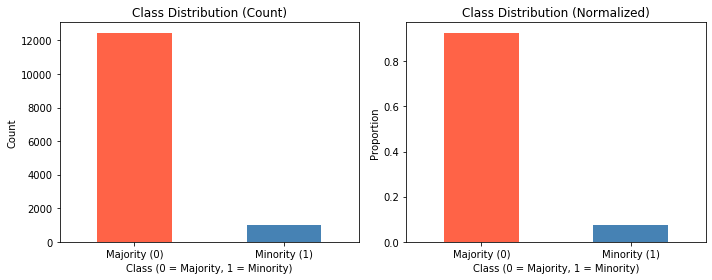

In [4]:
# Count the number of samples in each class
minority_count = df[df['DEFAULT'] == 1].shape[0]
majority_count = df[df['DEFAULT'] == 0].shape[0]
total_count = len(df)

# Calculate the proportions of each class
minority_ratio = minority_count / total_count  # Proportion of the minority class
majority_ratio = majority_count / total_count  # Proportion of the majority class

print(f"Minority class ratio: {minority_ratio:.4f}")
print(f"Majority class ratio: {majority_ratio:.4f}")

# Plot class distribution (standard count and normalized)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar chart for class count distribution
df['DEFAULT'].value_counts().plot(kind='bar', color=['#FF6347', '#4682B4'], ax=axes[0])
axes[0].set_title("Class Distribution (Count)")
axes[0].set_xlabel("Class (0 = Majority, 1 = Minority)")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(['Majority (0)', 'Minority (1)'], rotation=0)

# Bar chart for class distribution (normalized)
df['DEFAULT'].value_counts(normalize=True).plot(kind='bar', color=['#FF6347', '#4682B4'], ax=axes[1])
axes[1].set_title("Class Distribution (Normalized)")
axes[1].set_xlabel("Class (0 = Majority, 1 = Minority)")
axes[1].set_ylabel("Proportion")
axes[1].set_xticklabels(['Majority (0)', 'Minority (1)'], rotation=0)

plt.tight_layout()
plt.show()

shape of original training set: (10755,)
shape of SMOTE training set: (13512,)

y train: {0: 9974, 1: 781}
y train resampled: {0: 5970, 1: 7542}


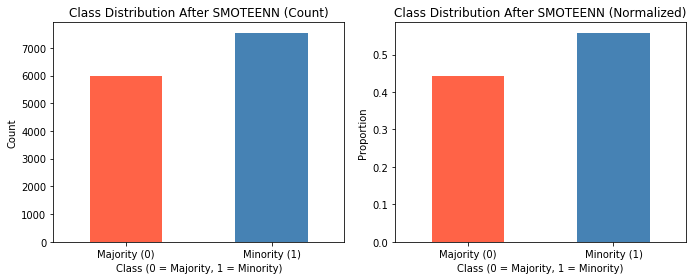

In [5]:
# Splitting data into training and testing sets
X = df.drop(columns=['DEFAULT'], axis=1)
y = df['DEFAULT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Handling class imbalance using SMOTEENN (SMOTE + Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=123)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(f'shape of original training set: {y_train.shape}')
print(f'shape of SMOTE training set: {y_train_resampled.shape}')
print()

print(f'y train: {dict(Counter(y_train))}')
print(f'y train resampled: {dict(Counter(y_train_resampled))}')

# Convert Counter to a pandas Series for easy plotting
resampled_counter = pd.Series(Counter(y_train_resampled))

# Plot class distribution (standard count and normalized)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar chart for class distribution (count) after SMOTEENN
resampled_counter.plot(kind='bar', color=['#FF6347', '#4682B4'], ax=axes[0])
axes[0].set_title("Class Distribution After SMOTEENN (Count)")
axes[0].set_xlabel("Class (0 = Majority, 1 = Minority)")
axes[0].set_ylabel("Count")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Majority (0)', 'Minority (1)'], rotation=0)

# Bar chart for class distribution (normalized) after SMOTEENN
resampled_counter_normalized = resampled_counter / resampled_counter.sum()

resampled_counter_normalized.plot(kind='bar', color=['#FF6347', '#4682B4'], ax=axes[1])
axes[1].set_title("Class Distribution After SMOTEENN (Normalized)")
axes[1].set_xlabel("Class (0 = Majority, 1 = Minority)")
axes[1].set_ylabel("Proportion")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Majority (0)', 'Minority (1)'], rotation=0)

# Display the plots
plt.tight_layout()
plt.show()

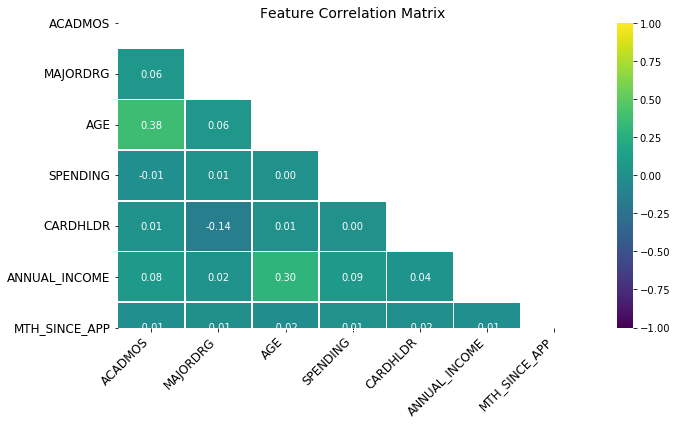

Highly Correlated Features (correlation > 0.9):


In [6]:
# Plotting the correlation matrix with a mask for the upper triangle
plt.figure(figsize=(10, 6))

# Compute the correlation matrix for features
corr_matrix = X.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap with the mask
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", cbar=True,
            annot_kws={'size': 10}, linewidths=0.5, vmin=-1, vmax=1, mask=mask)

plt.title("Feature Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keep y-axis labels horizontal
plt.tight_layout() 
plt.show()

# Identify pairs of highly correlated features (correlation > 0.9)
high_corr_pairs = np.where(np.abs(corr_matrix) > 0.9)
high_corr_pairs = [(corr_matrix.columns[x], corr_matrix.columns[y]) 
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]

# Display high correlation pairs
print("Highly Correlated Features (correlation > 0.9):")
for pair in high_corr_pairs:
    print(pair)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time=   1.3s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time=   1.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time=   1.0s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=7, n_est

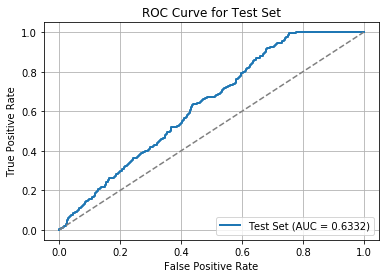

In [8]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300],     # Number of boosting rounds (trees)
    'learning_rate': [0.05, 0.1],   # Step size at each iteration
    'max_depth': [5, 7],            # Maximum depth of each tree
#    'gamma': [0, 0.1]              # Minimum loss reduction required to make a further partition
}

# Calculate the scale_pos_weight: ratio of majority class to minority class in the resampled data
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(
    random_state=123,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    eval_metric='logloss'  # Binary classification evaluation metric
)

# Define scoring metrics (F1 and AUC)
scoring_metrics = ['f1', 'roc_auc']

# Initialize GridSearchCV with StratifiedKFold and multiple scoring metrics
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    scoring=scoring_metrics,
    refit='roc_auc',  # refit='f1'
    verbose=2
    # n_jobs=-1  # Uncomment this if you want to use all cores for parallelization
)

# Fit the model using GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
print("Best Hyperparameters Found: ", grid_search.best_params_)

# Get the best estimator (the one with highest AUC)
best_model = grid_search.best_estimator_

# Evaluate the best model
best_f1 = grid_search.best_score_  # Best F1 score from the grid search
best_auc = grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_]  # Best AUC from the grid search

print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best AUC Score: {best_auc:.4f}")

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Print the classification report on the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# AUC for the test set
test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"Test Set AUC: {test_auc:.4f}")

# plot the ROC curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, label=f"Test Set (AUC = {roc_auc_test:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Classification Report for Fold 1: 
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1194
           1       0.90      0.97      0.93      1509

    accuracy                           0.92      2703
   macro avg       0.93      0.91      0.92      2703
weighted avg       0.92      0.92      0.92      2703

Fold 1 AUC: 0.9755


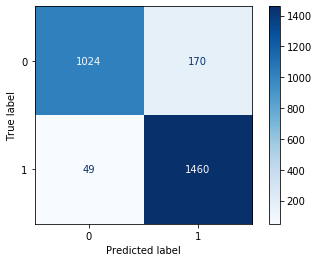

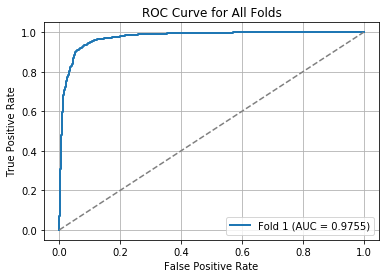

Classification Report for Fold 2: 
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1194
           1       0.92      0.96      0.94      1509

    accuracy                           0.93      2703
   macro avg       0.93      0.93      0.93      2703
weighted avg       0.93      0.93      0.93      2703

Fold 2 AUC: 0.9772


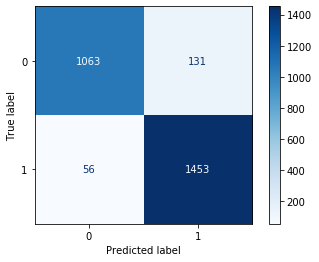

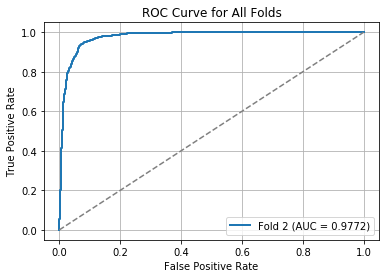

Classification Report for Fold 3: 
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1194
           1       0.91      0.96      0.93      1508

    accuracy                           0.92      2702
   macro avg       0.93      0.92      0.92      2702
weighted avg       0.92      0.92      0.92      2702

Fold 3 AUC: 0.9764


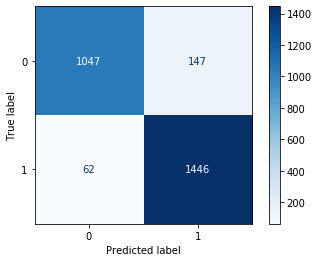

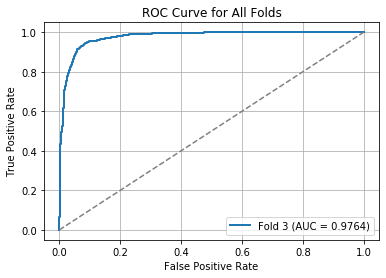

Classification Report for Fold 4: 
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1194
           1       0.90      0.96      0.93      1508

    accuracy                           0.92      2702
   macro avg       0.92      0.91      0.91      2702
weighted avg       0.92      0.92      0.91      2702

Fold 4 AUC: 0.9711


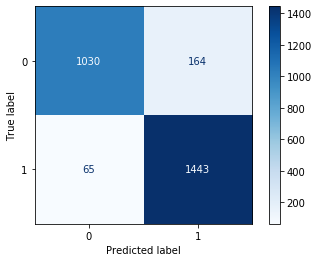

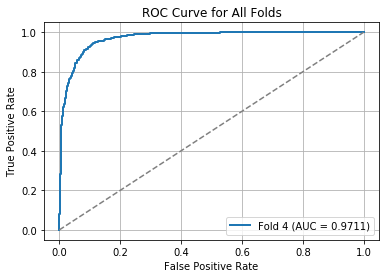

Classification Report for Fold 5: 
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1194
           1       0.91      0.97      0.94      1508

    accuracy                           0.93      2702
   macro avg       0.93      0.92      0.92      2702
weighted avg       0.93      0.93      0.93      2702

Fold 5 AUC: 0.9790


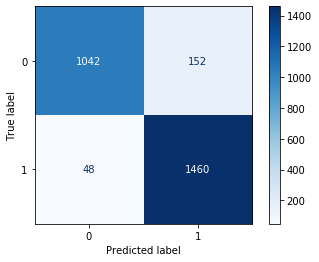

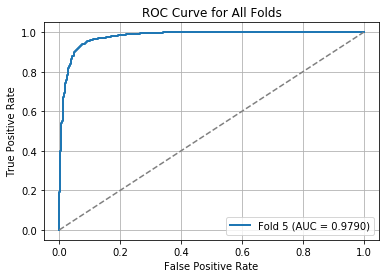

In [9]:
# Retrieve the best parameters from grid search
best_params = grid_search.best_params_

# StratifiedKFold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

f1scores = []
aucs = []

# Calculate the scale_pos_weight: ratio of majority class to minority class in the resampled data
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
scale_pos_weight

# Set up the XGBoost model with best hyperparameters from grid search
model = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],  
    learning_rate=best_params['learning_rate'],  
    max_depth=best_params['max_depth'], 
#    gamma=best_params['gamma'],  
    scale_pos_weight=scale_pos_weight,  # Set the scale_pos_weight to handle imbalance
    random_state=123,
    eval_metric='logloss'  # Evaluation metric for binary classification
)

for fold, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
    # Split the data into training and validation sets for each fold
    X_train_fold, X_val_fold = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]
    
    # Fit the model
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation fold
    y_pred_fold = model.predict(X_val_fold)
    y_pred_proba_fold = model.predict_proba(X_val_fold)[:, 1]  # Get probability of the positive class
    
       
    # Calculate F1 score and append to the list
    f1 = f1_score(y_val_fold, y_pred_fold)
    f1scores.append(f1)
    
    # Print classification report for analysis
    print(f"Classification Report for Fold {fold+1}: \n{classification_report(y_val_fold, y_pred_fold)}")
    
    
    # Calculate AUC score and append to the list
    auc_score = roc_auc_score(y_val_fold, y_pred_proba_fold)
    aucs.append(auc_score)
    
    # Print AUC for this fold
    print(f"Fold {fold+1} AUC: {auc_score:.4f}")
    
    
    #plot the confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format='d', cmap='Blues');
    plt.show()
    

    # Plot ROC curve for this fold
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred_proba_fold)
    roc_auc_score_fold = auc(fpr, tpr)  # Renamed to avoid conflict
    
    
    plt.plot(fpr, tpr, lw=2, label=f"Fold {fold+1} (AUC = {roc_auc_score_fold:.4f})")

    # Plot settings for ROC curve
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for All Folds')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [10]:
# Print the F1 score across all folds
print(f'Mean F1 score: {np.mean(f1scores):.4f}')
print(f'Standard Deviation of F1 score: {np.std(f1scores):.4f}')
print(f'\nList of F1 Score from StratifiedKFold cross-validation: \n{f1scores}')
print()

# Print the AUC score across all folds
print(f"Average AUC Score: {np.mean(aucs):.4f}")
print(f'Standard Deviation of AUC score: {np.std(aucs):.4f}')
print(f'\nList of AUC Score from StratifiedKFold cross-validation: \n{aucs}')

Mean F1 score: 0.9330
Standard Deviation of F1 score: 0.0045

List of F1 Score from StratifiedKFold cross-validation: 
[0.930232558139535, 0.9395408988037505, 0.9326023863269913, 0.9264847512038524, 0.9358974358974359]

Average AUC Score: 0.9758
Standard Deviation of AUC score: 0.0027

List of AUC Score from StratifiedKFold cross-validation: 
[0.9755431675718998, 0.9772337499292353, 0.9763544735170104, 0.9710510998849242, 0.9790308749761185]


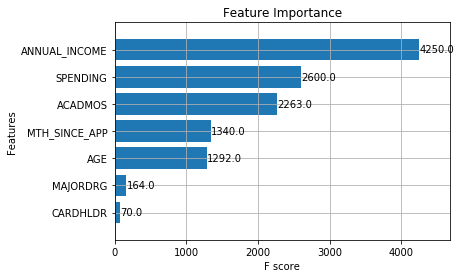

In [11]:
# Plot feature importance using the trained model
xgb.plot_importance(model, 
                    importance_type='weight',  # 'gain' or 'cover' can be alternatives
                    max_num_features=10,  # Limit to top N features
                    height=0.8,  # Bar height
                    title='Feature Importance',  # Title of the plot
                    show_values=True)  # Display values next to bars
plt.show()

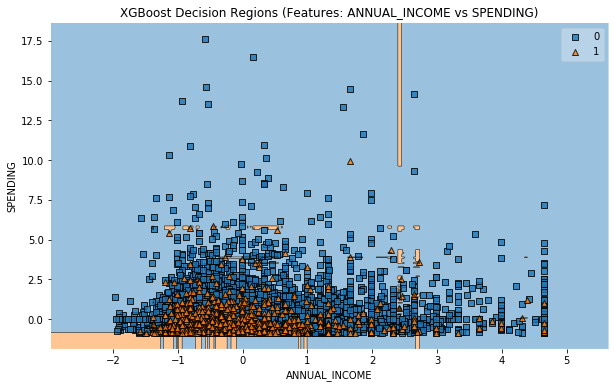

In [12]:
# decision region visualization

# Select the two most important features for visualization
top_feature_names = ['ANNUAL_INCOME', 'SPENDING']

X_combined = X[top_feature_names].values  # Extract the two selected features from the dataframe
y_combined = y.values  # Convert y to a NumPy array
y_combined = y_combined.astype(np.int_)

# Standardize the features
scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)


# Train a new model using only the two selected features for visualization
model_viz = xgb.XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=7, objective='binary:logistic')#'multi:softprob')

model_viz.fit(X_combined, y_combined)  # Train on the two most important features

# Plot decision regions for the two selected features
fig, ax = plt.subplots(figsize=(10, 6))


scatter_highlight_kwargs = {'s': 120, 'label': 'Test data', 'alpha': 0.7}

plot_decision_regions(X_combined, y_combined, clf=model_viz, legend=1, ax=ax,                       
                      # X_highlight=X_test_combined,                   
                      scatter_highlight_kwargs=scatter_highlight_kwargs);


ax.set_xlabel(top_feature_names[0])
ax.set_ylabel(top_feature_names[1])
ax.set_title(f'XGBoost Decision Regions (Features: {top_feature_names[0]} vs {top_feature_names[1]})')
plt.show()

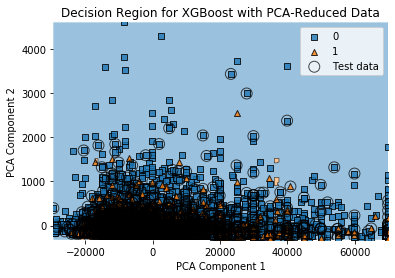

In [13]:
from sklearn.decomposition import PCA

# Perform PCA to reduce the data to 2D
pca = PCA(n_components=2)

# Fit and transform the training data to 2D
X_train_pca = pca.fit_transform(X_train)

# Transform the test data using the same PCA
X_test_pca = pca.transform(X_test)

# Train the model on the PCA-reduced data
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=7,
    scale_pos_weight=scale_pos_weight,  # Use the correct scale_pos_weight if needed
    random_state=123,
    eval_metric='logloss'
)

model.fit(X_train_pca, y_train)  # Train on PCA-reduced data

# Combine train and test data for plotting
X_combined = np.vstack((X_train_pca, X_test_pca))  # Combine the training and testing data
y_combined = np.hstack((y_train, y_test))  # Combine the labels

# Customize the scatter_highlight_kwargs for test data points
scatter_highlight_kwargs = {'s': 120, 'label': 'Test data', 'alpha': 0.7}

# Plotting the decision region
plot_decision_regions(X_combined, y_combined, clf=model, legend=2,
                      X_highlight=X_test_pca,  # Highlight the test data
                      scatter_highlight_kwargs=scatter_highlight_kwargs)

plt.title('Decision Region for XGBoost with PCA-Reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='best')
plt.show()